In [ ]:
######################################################################
## 08_ANALYSIS: Shell Age Modeling
######################################################################

Adj. R^2 = 0.873, Dev. explained = 89.1%, edf = 2.56, F = 44.43, p < <2e-16, RMSE = 0.83 years# A tibble: 7 × 3
  Sample `Length (mm)` `Predicted age (y)`
  <chr>          <dbl>               <dbl>
1 MC09              18                0.63
2 MC11             139                6.34
3 MC14             111                4.92
4 MC15             124                5.59
5 MC18             164                7.51
6 MC19             183                8.3 
7 MC24              30                1.65
Predicted ages range 0.63–8.3 years (median 5.59 years)

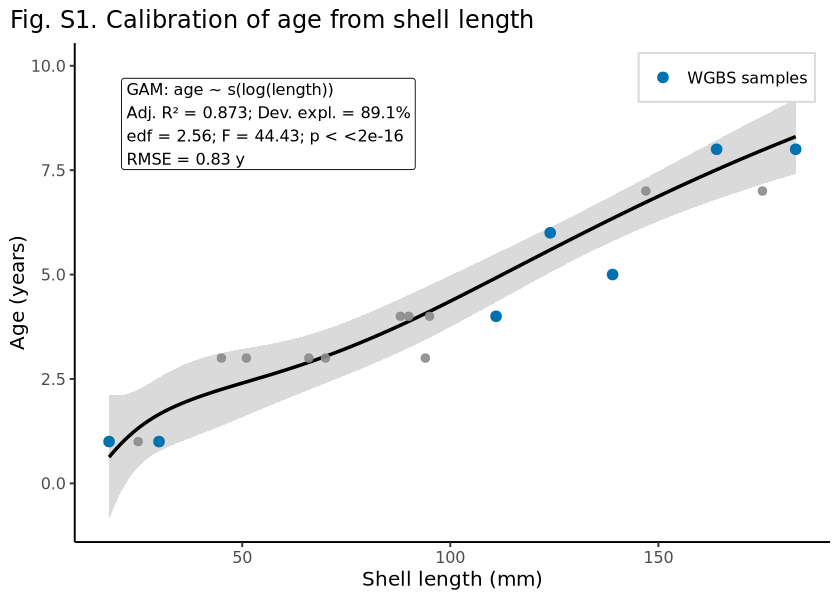

In [6]:
######################################################################
## BLOCK 1: GAM calibration + figure + WGBS age predictions
######################################################################

suppressMessages({
  library(mgcv); library(dplyr); library(ggplot2); library(scales); library(glue); library(tibble)
})

## (A) Data ---------------------------------------------------------------------
calib <- tribble(
  ~id, ~length_mm, ~age_years,
   9,      18,        1,
  25,      25,        1,
  24,      30,        1,
  17,      45,        3,
  10,      51,        3,
  23,      66,        3,
   7,      70,        3,
  22,      88,        4,
  12,      90,        4,
  16,      94,        3,
   8,      95,        4,
  14,     111,        4,
  15,     124,        6,
  11,     139,        5,
  21,     147,        7,
  18,     164,        8,
  20,     165,       10,
  13,     175,        7,
  19,     183,        8
) %>%
  mutate(logL = log(length_mm))

## (B) Fit GAM (REML) -----------------------------------------------------------
m <- gam(age_years ~ s(logL, k = 4), data = calib, method = "REML")
s <- summary(m)

# Metrics
r2_adj <- s$r.sq                      # mgcv prints this as "R-sq.(adj)"
devexp <- s$dev.expl                  # "Deviance explained"
edf    <- as.numeric(s$s.table[1, "edf"])
Fstat  <- as.numeric(s$s.table[1, "F"])
pval   <- as.numeric(s$s.table[1, "p-value"])
rmse   <- sqrt(mean((calib$age_years - fitted(m))^2))

cat(glue("Adj. R^2 = {round(r2_adj,3)}, Dev. explained = {round(100*devexp,1)}%, ",
         "edf = {round(edf,2)}, F = {round(Fstat,2)}, p < {format.pval(pval, digits=2)}, ",
         "RMSE = {round(rmse,2)} years\n"))

## (C) Predict ages for WGBS individuals (no dplyr deprecation) -----------------
wgbsi <- tibble(sample = c("MC09","MC24","MC11","MC14","MC15","MC18","MC19"),
                id     = c(9, 24, 11, 14, 15, 18, 19))

pred_tbl <- wgbsi %>%
  left_join(calib, by = "id") %>%
  mutate(pred_age = as.numeric(predict(m, newdata = pick(logL))))

print(
  pred_tbl %>%
    transmute(Sample = sample, `Length (mm)` = length_mm, `Predicted age (y)` = round(pred_age, 2)) %>%
    arrange(Sample),
  n = Inf
)

cat(glue("\nPredicted ages range {round(min(pred_tbl$pred_age),2)}–{round(max(pred_tbl$pred_age),2)} years ",
         "(median {round(median(pred_tbl$pred_age),2)} years)\n"))

## (D) Build Figure S1: GAM with 95% CI, highlight WGBS samples -----------------
# Prediction grid on original length scale
new_len <- tibble(length_mm = seq(min(calib$length_mm), max(calib$length_mm), length.out = 300),
                  logL = log(length_mm))
pred    <- as.data.frame(predict(m, newdata = new_len, se.fit = TRUE))
new_len$fit <- pred$fit
new_len$lo  <- pred$fit - 1.96 * pred$se.fit
new_len$hi  <- pred$fit + 1.96 * pred$se.fit

# Mark WGBS points
calib$WGBS <- calib$id %in% wgbsi$id

# Stats label for the plot
stats_lab <- glue("GAM: age ~ s(log(length))\n",
                  "Adj. R² = {round(r2_adj,3)}; Dev. expl. = {round(100*devexp,1)}%\n",
                  "edf = {round(edf,2)}; F = {round(Fstat,2)}; p < {format.pval(pval, digits = 2)}\n",
                  "RMSE = {round(rmse,2)} y")

# Theme
base_theme <- theme_classic(base_size = 12) +
  theme(legend.position = c(0.02, 0.98),
        legend.justification = c(0,1),
        legend.title = element_blank(),
        legend.background = element_rect(fill = "white", color = "grey85"),
        plot.title.position = "plot")

# --- figure tweaks: legend location & stats box placement ---
base_theme <- theme_classic(base_size = 12) +
  theme(legend.position      = c(0.98, 0.98),   # top-right
        legend.justification = c(1, 1),
        legend.title         = element_blank(),
        legend.background    = element_rect(fill = "white", color = "grey85"),
        plot.title.position  = "plot")

# stats label stays in the top-left of the panel
stats_lab <- glue(
  "GAM: age ~ s(log(length))\n",
  "Adj. R² = {round(r2_adj,3)}; Dev. expl. = {round(100*devexp,1)}%\n",
  "edf = {round(edf,2)}; F = {round(Fstat,2)}; p < {format.pval(pval, digits = 2)}\n",
  "RMSE = {round(rmse,2)} y"
)

p_s1 <- ggplot() +
  geom_ribbon(data = new_len, aes(x = length_mm, ymin = lo, ymax = hi), alpha = 0.18) +
  geom_line(data = new_len, aes(x = length_mm, y = fit), linewidth = 1) +
  geom_point(data = calib %>% filter(!WGBS), aes(length_mm, age_years),
             color = "grey55", size = 2, alpha = 0.9) +
  geom_point(data = calib %>% filter(WGBS),  aes(length_mm, age_years, color = "WGBS samples"),
             size = 2.6) +
  scale_color_manual(values = c("WGBS samples" = "#0072B2")) +
  annotate("label",
           x = min(calib$length_mm) + 3,                  # safely left
           y = max(calib$age_years) - 0.3,                # safely top
           label = stats_lab, size = 3.4, hjust = 0, vjust = 1,
           label.size = 0.25, label.r = unit(0.15, "lines"), fill = "white") +
  labs(title = "Fig. S1. Calibration of age from shell length",
       x = "Shell length (mm)", y = "Age (years)") +
  base_theme

# Show in notebook at a comfortable size
INLINE_W <- 7; INLINE_H <- 5; INLINE_DPI <- 160
old_opts <- options(repr.plot.width = INLINE_W, repr.plot.height = INLINE_H, repr.plot.res = INLINE_DPI)
print(p_s1)
options(old_opts)

# Save high-res PDF/PNG for supplement
ggsave("FigS1_GAM_age_vs_length.pdf", p_s1, width = 7, height = 5, units = "in", dpi = 300, useDingbats = FALSE)
ggsave("FigS1_GAM_age_vs_length.png", p_s1, width = 7, height = 5, units = "in", dpi = 300)